# Pytorch的层次结构

章我们介绍Pytorch中5个不同的层次结构：

1. 硬件层
2. 内核层
3. 低阶API
4. 中阶API
5. 高阶API【torchkeras】

以线性回归和DNN二分类模型为例，直观对比展示在不同层级实现模型的特点

---
Pytorch的层次结构从低到高可以分成如下五层:
1. 第一层也是最底层，为硬件层，Pytorch支持CPU、GPU加入计算资源池
2. 第二层为C++实现的内核
3. 第三层为Python实现的操作符，提供了封装C++内核的低级API指令
    1. 主要包括各种张量操作算子、自动微分、变量管理
    2. 如torch.tensor,torch.cat,torch.autograd.grad,nn.Module. 
4. 第四层为Python实现的模型组件，对低级API进行了函数封装，主要包括各种模型层，损失函数，优化器，数据管道等等
5. 第五层为Python实现的模型接口，

Pytorch没有官方的高阶API。为了便于训练模型，作者仿照keras中的模型接口，使用了不到300行代码，封装了Pytorch的高阶模型接口torchkeras.Model

# 低阶API示范

使用Pytorch的低阶API实现线性回归模型和DNN二分类模型

Pytorch低阶API主要包括：
1. 张量操作
2. 计算图
3. 自动微分

## 线性回归模型
### 准备数据

In [1]:
import os 
import datetime
import numpy as np
import pandas as pd
import torch
from torch import nn

# 样本数量
n = 400
# torch.rand 是均匀分布
X = 10* torch.rand([n,2]) -5.0
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
# torch.normal 是正态分布N(0,2)
Y = X@w0 + b0 + torch.normal(0.0,2.0, size=[n,1])

/home/beta/anaconda3/envs/lye/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


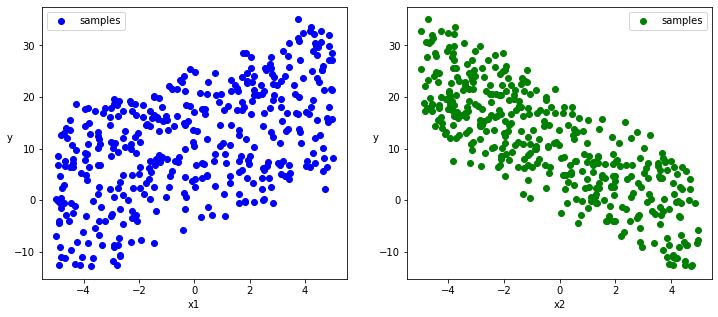

In [4]:
# 数据可视化
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(), Y[:,0].numpy(), c= "b", label ="samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(), Y[:,0].numpy(),c='g', label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.show()

In [5]:
# 构建管道迭代器
def data_iter(features, labels, batch_size = 8):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本的读取是随机的
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i:min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

In [6]:
# 测试数据管道的效果
batch_size = 8
(features, labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[ 0.2817, -3.9612],
        [ 3.1465, -1.2291],
        [-4.7728, -0.4799],
        [-0.1510, -2.9207],
        [ 4.0298, -0.4868],
        [-3.9441, -1.8258],
        [-2.5211, -2.6427],
        [ 4.1764, -4.9614]])
tensor([[17.5754],
        [23.1949],
        [ 2.4088],
        [18.1597],
        [17.0976],
        [ 7.7015],
        [13.3692],
        [32.7076]])


### 定义模型

In [7]:
class LinearRegression:
    def __init__(self):
        self.w = torch.randn_like(w0, requires_grad=True)
        self.b = torch.randn_like(b0, requires_grad=True)
    # 正向传播
    def forward(self, x):
        return x@self.w +self.b
    
    def loss_func(self, y_pred, y_true):
        return torch.mean((y_pred-y_true)**2 / 2)

In [8]:
model = LinearRegression()

### 训练模型

In [9]:
def train_step(model, features, labels):
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    
    # 反向传播求梯度
    loss.backward()
    # no_grad()避免梯度记录
    with torch.no_grad():
        model.w -= 0.001 * model.w.grad
        model.b -= 0.001 * model.b.grad
        
        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [10]:
batch_size = 10
(features, labels)  =next(data_iter(X,Y, batch_size))
train_step(model, features, labels)

tensor(129.2946, grad_fn=<MeanBackward0>)

In [11]:
import datetime
def printbar():
    print("="*60, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        for feature, label in data_iter(X,Y,batch_size):
            loss = train_step(model, feature, label)
        # 每200个epoch打印一次信息
        if epoch % 200 ==0:
            printbar()
            print("epoch=%d  | loss=%.2f" %(epoch, loss.item()))
            print("model.w=", model.w.data)
            print("model.b=", model.b.data)

train_model(model, epochs=1000)

==================== 2021-08-11 20:58:29
epoch=200  | loss=0.89
model.w= tensor([[ 1.9441],
        [-3.0093]])
model.b= tensor([[9.9818]])
==================== 2021-08-11 20:58:31
epoch=400  | loss=2.25
model.w= tensor([[ 1.9455],
        [-3.0119]])
model.b= tensor([[9.9864]])
==================== 2021-08-11 20:58:34
epoch=600  | loss=2.29
model.w= tensor([[ 1.9464],
        [-3.0102]])
model.b= tensor([[9.9859]])
==================== 2021-08-11 20:58:36
epoch=800  | loss=1.85
model.w= tensor([[ 1.9448],
        [-3.0126]])
model.b= tensor([[9.9863]])
==================== 2021-08-11 20:58:39
epoch=1000  | loss=1.96
model.w= tensor([[ 1.9472],
        [-3.0098]])
model.b= tensor([[9.9856]])


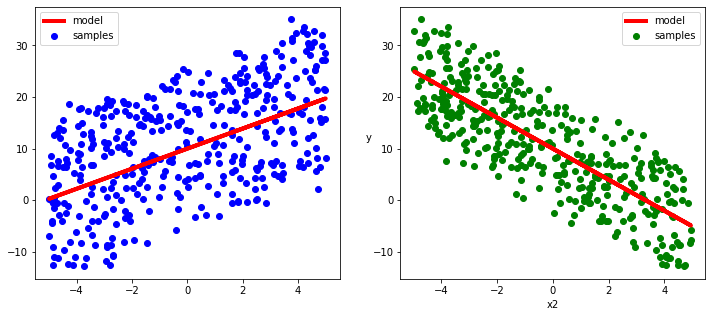

In [15]:
# 结果可视化

plt.figure(figsize=(12,5))

# 121表示一行两列，占1列
ax1 = plt.subplot(121)

# 122表示一行两列，占2列
ax2 = plt.subplot(122)

ax1.scatter(X[:,0].numpy(), Y[:,0].numpy(),c ="b",label="samples")
ax1.plot(X[:,0].numpy(), (model.w[0].data*X[:,0] + model.b[0].data).numpy(), "-r", linewidth=4.0, label="model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c="g",label="samples")
ax2.plot(X[:,1].numpy(), (model.w[1].data * X[:,1] + model.b[0].data).numpy(),  "-r", linewidth=4.0, label="model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.show()


## DNN 二分类模型

### 数据准备

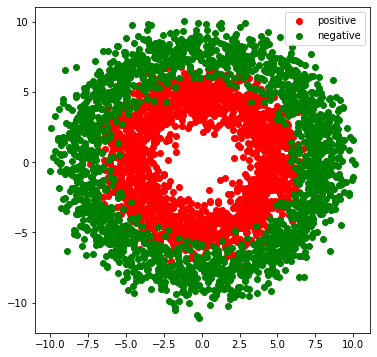

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

n_positive=2000
n_negative =2000



# 生成正样本
r_p = 5.0+ torch.normal(0.0,1.0, size=[n_positive,1])
# 角度
theta_p = 2*np.pi * torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p), r_p*torch.sin(theta_p)], axis = 1)
# 正样本的标签为1
Yp= torch.ones_like(r_p)

# 生成负样本
# r_n = 8.0 + torch.normal(0.0,0.1, size=[n_negative, 1])
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n* torch.cos(theta_n), r_n* torch.sin(theta_n)], axis=1)
# 负样本的Y(标签)为0
Yn = torch.zeros_like(r_n)

# 汇总样本
X = torch.cat([Xp,Xn], axis=0)
Y = torch.cat([Yp ,Yn], axis=0)

# 可视化
plt.figure(figsize=(6,6))
# 坐标点为(cos(x), sin(x))

plt.scatter(Xp[:,0].numpy(), Xp[:,1].numpy(), c='r')
plt.scatter(Xn[:,0].numpy(), Xn[:,1].numpy(), c='g')
plt.legend(["positive", "negative"])
plt.show()

In [38]:
# 构建管道迭送器
# features = X
# labels = Y
def data_iter(features , labels, batch_size = 8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i:min(i+batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0,indexs)

# 测试数据管道
batch_size = 8
(features,labels) = next(data_iter(X,Y, batch_size))
print(features)
print(labels)

tensor([[ 0.5525,  4.4502],
        [ 4.4006, -4.6638],
        [ 6.8763,  3.8039],
        [ 7.5212,  1.4692],
        [ 5.4698,  4.3394],
        [ 4.3909, -6.5561],
        [ 3.5280,  2.7674],
        [ 7.7704,  5.3042]])
tensor([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])


### 定义模型

In [52]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        # 点的坐标是(x,y) 1*2 维度的
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.randn(1,1))
        
    def forward(self,x):
        x = torch.relu(x@self.w1+self.b1)
        x = torch.relu(x@self.w2+self.b2)
        y = torch.sigmoid(x@self.w3+self.b3)
        return y
    
    # 交叉熵
    def loss_func(self, y_pred, y_true):
        #避免log0错误
        eps = 1e-7
        # 将预测值限制在[1e-7, 1-(1e-7)]范围内
        # torch.clamp(input, min=None, max=None, *, out=None) → Tensor
        y_pred = torch.clamp(y_pred, eps, 1.0-eps)
        # 交叉熵公式 -x*log(x) -(1-x)log(1-x)
        bce = -y_true* torch.log(y_pred) - (1-y_true)* torch.log(1-y_pred)
        return torch.mean(bce)
    
    def metric_func(self, y_pred, y_true):
        # 如果y_pred 大于0.5，直接赋值为1，如果y_Pred 小于0.5， 直接赋值为0
        y_pred = torch.where(y_pred>0.5, torch.ones_like(y_pred,dtype = torch.float32), 
                             torch.zeros_like(y_pred, dtype=torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [54]:
# 测试模型结构
batch_size = 10
(features, labels) = next(data_iter(X,Y,batch_size))

# 把特征给模型，看看模型的输出
predictions = model(features)

loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

# loss = model.loss_func(labels, predictions)
# metric = model.metric_func(labels,predictions)
print("init loss:", loss.item())
print("init acc:", metric.item())


init loss: 2.205746650695801
init acc: 0.699999988079071


### 训练模型

In [55]:
import datetime
def train_step(model, features, labels):
    predictions  = model.forward(features)
    loss = model.loss_func(predictions, labels)
    acc = model.metric_func(predictions, labels)
    
    # 反向求梯度
    loss.backward()
    
    # 更新参数 = optimizer
    for param in model.parameters():
        param.data = (param.data - 0.01* param.grad.data)
    
    model.zero_grad()
    return loss.item(), acc.item()

def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, acc_list=[],[]
        for features, labels in data_iter(X,Y,20):
            loss_item, acc_item = train_step(model, features, labels)
            loss_list.append(loss_item)
            acc_list.append(acc_item)
        loss_average = np.mean(loss_list)
        acc_average = np.mean(acc_list)
        # 输出信息
        if epoch%100==0:
            print("="*80, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            print(f"epoch={epoch} | loss={loss_average} | acc={acc_average}")

train_model(model, epochs=1000)

================================================================================ 2021-08-12 14:03:25
epoch=100 | loss=0.2995688025280833 | acc=0.8500000002980233
================================================================================ 2021-08-12 14:03:45
epoch=200 | loss=0.1929070571716875 | acc=0.9212499934434891
================================================================================ 2021-08-12 14:04:05
epoch=300 | loss=0.18185354511253535 | acc=0.9244999909400939
================================================================================ 2021-08-12 14:04:25
epoch=400 | loss=0.17627978927455842 | acc=0.9279999926686286
================================================================================ 2021-08-12 14:04:46
epoch=500 | loss=0.17671862166374921 | acc=0.9249999940395355
================================================================================ 2021-08-12 14:05:06
epoch=600 | loss=0.17313356693834067 | acc=0.9287499928474426
========================

### 结果可视化

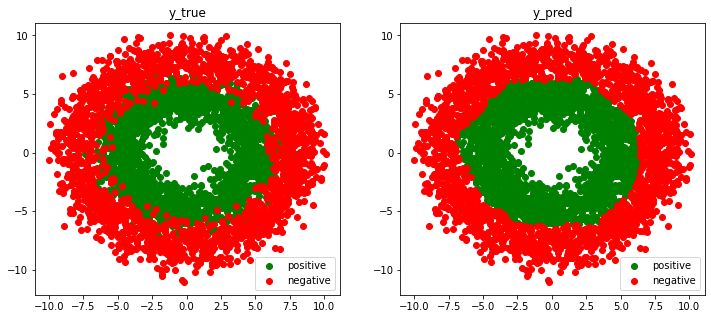

In [60]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.scatter(Xp[:,0],Xp[:,1], c='g')
ax1.scatter(Xn[:,0],Xn[:,1],c='r')
ax1.legend(["positive", "negative"])
ax1.set_title("y_true")
# 
Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1], c='g')
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1], c='r')
ax2.legend(["positive", "negative"])
ax2.set_title("y_pred")

plt.show()

# 中阶API示范

下面的范例使用Pytorch的**中阶API**实现线性回归模型和和DNN二分类模型

Pytorch的中阶API主要包括:
1. 各种模型层
2. 损失函数
3. 优化器
4. 数据管道

## 线性回归模型

### 准备数据

In [62]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

n = 400
# 生成数据集， rand是均匀分布
# y_1 = 2x + 10
# y_2 = -3x + 10
# X.shape = [400,2] 其中二维度用于分别向y1和y2输入
X = 10* torch.rand(n,2) -5.0
#w0 和 b0 是需要 优化 的参数 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])

Y = X@w0 + b0 + torch.normal(0.0, 2.0, size=(n,1))

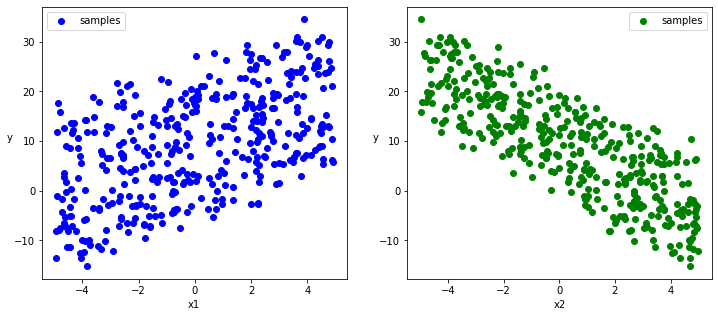

In [63]:
#数据可视化

plt.figure(figsize=(12,5))
ax1= plt.subplot(121)
ax1.scatter(X[:,0], Y[:,0], c= 'b', label="samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1], Y[:,0],c='g', label="samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

In [66]:
# 构建数据管道
dataset = TensorDataset(X,Y)
# 相当于上面的data_iter
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=2)

### 定义模型

In [67]:
# 线性模型
model = nn.Linear(2,1)
# 用于计算模型的损失值
model.loss_func = nn.MSELoss()
# 用于更新参数
model.optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

### 训练模型

In [68]:
def train_step(model, features, labels):
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    loss.backward()
    # 更新模型参数
    model.optimizer.step()
    # 梯度清零
    model.optimizer.zero_grad()
    return loss.item()
# 测试train_step效果
features, labels = next(iter(dataloader))
train_step(model, features, labels)

73.77377319335938

In [69]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        for features, labels in dataloader:
            loss = train_step(model, features, labels)
        if epoch%50 ==0:
            print("="*80, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            print(f"epoch={epoch} | loss={loss}")
            w = model.state_dict()["weight"]
            b = model.state_dict()["bias"]
            print("w=", w)
            print("b=", b)

train_model(model, epochs=200)

================================================================================ 2021-08-12 17:52:28
epoch=50 | loss=5.213642597198486
w= tensor([[ 2.0363, -3.0390]])
b= tensor([9.9349])
================================================================================ 2021-08-12 17:52:34
epoch=100 | loss=3.495203733444214
w= tensor([[ 2.0164, -3.1018]])
b= tensor([9.9111])
================================================================================ 2021-08-12 17:52:40
epoch=150 | loss=2.992335319519043
w= tensor([[ 2.0737, -2.9961]])
b= tensor([9.9007])
================================================================================ 2021-08-12 17:52:45
epoch=200 | loss=3.6544978618621826
w= tensor([[ 2.0238, -2.9302]])
b= tensor([9.9329])


### 结果可视化

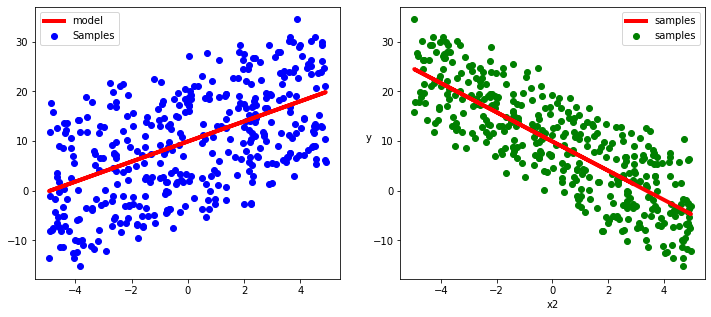

In [72]:
w = model.state_dict()["weight"]
b = model.state_dict()["bias"]

plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.scatter(X[:,0], Y[:,0], c='b', label="Samples")
ax1.plot(X[:,0], w[0,0]*X[:,0]+b[0], '-r', linewidth=4.0, label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2.scatter(X[:,1],Y[:,0], c='g', label="samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0], '-r', linewidth=4.0, label="samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.show()

## DNN二分类模型

### 准备数据

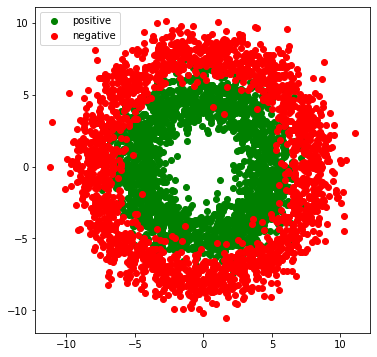

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

n_negative, n_positive = 2000, 2000

# 正样本
r_p = 5.0 + torch.normal(0.0,1.0, size=[n_positive,1])
theta_p = 2*np.pi*torch.rand([n_positive,1])
# 在列的维度上合并
Xp = torch.cat([r_p*torch.cos(theta_p), r_p*torch.sin(theta_p)], axis = 1)
Yp = torch.ones_like(r_p)

# 负样本
r_n = 8.0 + torch.normal(0.0,1.0, size=[n_negative,1])
theta_n = 2*np.pi * torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n), r_n*torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

X = torch.cat([Xp, Xn],axis=0)
Y = torch.cat([Yp,Yn], axis=0)

# 可视化
plt.figure(figsize=(6,6))
plt.scatter(Xp[:,0],Xp[:,1], c='g', label ="positive")
plt.scatter(Xn[:,0],Xn[:,1],c='r',label="negative")
plt.legend()
plt.show()

In [80]:
# 构建数据传输通道
dataset = TensorDataset(X,Y)
dataloader = DataLoader(dataset, batch_size=10, shuffle =True, num_workers = 2)

### 定义模型

In [89]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
    
    def loss_func(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true)
    
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred>0.5, torch.ones_like(y_pred, dtype = torch.float32), 
                             torch.zeros_like(y_pred, dtype=torch.float32))
        acc = torch.mean(1-torch.abs(y_pred-y_true))
        return acc
    
    # 优化器 
    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(),lr=0.001)


model = DNNModel()

In [91]:
# 测试模型
(features, labels) =next(iter(dataloader))
predictions = model(features)

loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

print("init loss:", loss.item())
print("init acc:", metric.item())

init loss: 0.674096941947937
init acc: 0.6000000238418579


### 训练模型

In [93]:
def train_step(model,features, labels):
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    # 反向传播 
    loss.backward()
    
    #更新模型参数 
    model.optimizer.step()
    model.optimizer.zero_grad()
    
    return loss.item(), metric.item()

# 测试 train_step 
features, labels = next(iter(dataloader))
train_step(model,features,labels)

(0.7238947749137878, 0.4000000059604645)

In [ ]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, acc_list =[],[]
        for features, labels in dataloader:
            